In [ ]:
import os
import ollama
import json
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
current_dir = os.getcwd()
pdf_directory = os.path.join(current_dir, 'star wars')


# Dictionary to store index, content, embedding, and metadata
vector_db = {}

# Initialize index counter
index = 0

# Helper function to extract the movie name from the filename
def extract_movie_name(filename):
    # Remove file extension and replace underscores or hyphens with spaces
    movie_name = os.path.splitext(filename)[0].replace('_', ' ').replace('-', ' ')
    return movie_name

# Loop through each PDF in the directory
for filename in os.listdir(pdf_directory):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(pdf_directory, filename)
        print(f"Processing file: {pdf_path}")
        
        # Load the PDF
        loader = PyPDFLoader(pdf_path)
        pages = loader.load_and_split()
        
        # Extract the title (assuming it's on the first page and first line)
        title = pages[0].page_content.split("\n")[0]
        
        # Extract the movie name from the filename
        movie_name = extract_movie_name(filename)
        
        # Split the document into chunks
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=80)
        chunks = text_splitter.split_documents(pages)
        
        # Process each chunk
        for chunk in chunks:
            # Get chunk content (text)
            content = chunk.page_content
            
            # Generate embedding for the chunk using the Ollama embedding model
            response = ollama.embeddings(model="mxbai-embed-large", prompt=content)
            embedding = response["embedding"]
            
            # Create a dictionary entry for this chunk
            vector_db[f"index_{index}"] = {
                "content": content,
                "embedding": embedding,
                "metadata": {
                    "title": title,
                    "movie": movie_name  # Add the movie name to the metadata
                }
            }
            
            # Increment the index
            index += 1

# Save the dictionary as a JSON file
output_file = os.path.join(current_dir, 'star wars', 'vector_db.json')
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(vector_db, f, ensure_ascii=False, indent=4)

print(f"Vector database saved to {output_file}")


Processing file: c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\Data_Viz\rag\star wars\A_New_Hope.pdf


c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


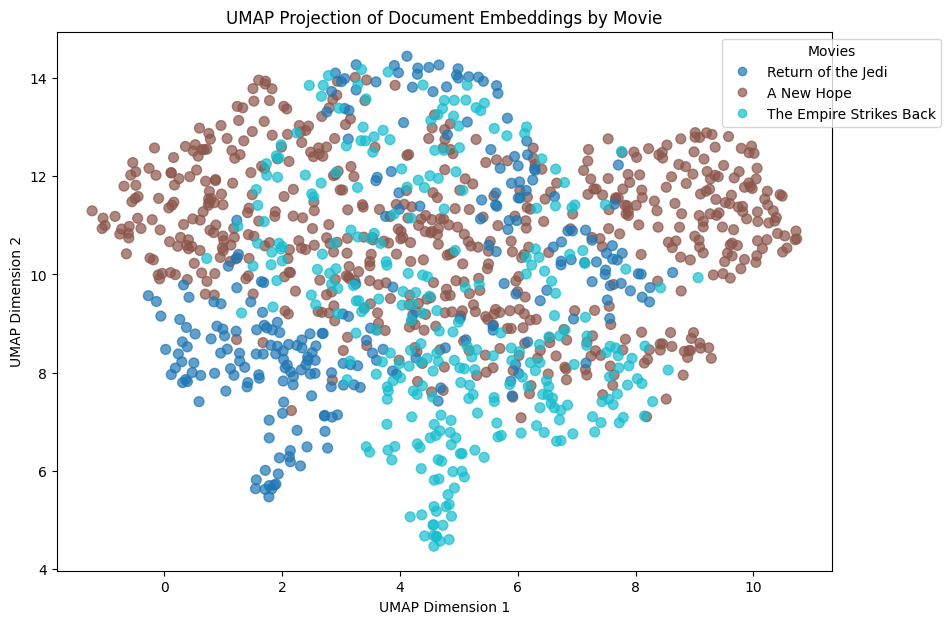

In [1]:
import json
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)


embeddings = []
contents = []
titles = []
movies = [] 

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie']) 

embeddings = np.array(embeddings)

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

umap_reducer = umap.UMAP(n_neighbors=9, n_components=2, min_dist=0.5, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)

unique_movies = list(set(movies))  
color_map = {movie: idx for idx, movie in enumerate(unique_movies)}  
colors = [color_map[movie] for movie in movies]  

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, cmap='tab10', s=50, alpha=0.7)

legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                     labels=unique_movies, 
                     title="Movies", 
                     loc="upper right", bbox_to_anchor=(1.15, 1))

plt.title('UMAP Projection of Document Embeddings by Movie')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.show()


c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


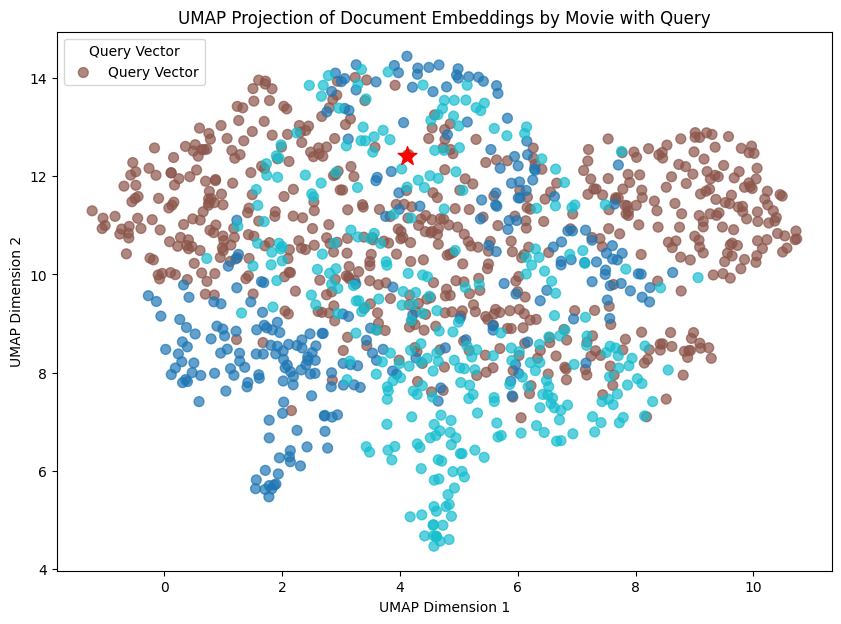

In [2]:
import json
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from ollama import embeddings as ollama_embeddings  

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)

# Step 2: Extract embeddings, content, titles, and movie names from the JSON
embeddings = []
contents = []
titles = []
movies = []  # We'll store the movie names here

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie'])  # Extract the movie name for coloring

# Convert embeddings list into a NumPy array for further processing
embeddings = np.array(embeddings)

# Step 3: Standardize the embeddings before applying UMAP
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 4: Apply UMAP for dimensionality reduction to 2D
umap_reducer = umap.UMAP(n_neighbors=9, n_components=2, min_dist=0.5, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)

# Step 5: Create a color map for movies
unique_movies = list(set(movies))  # Get a list of unique movie names
color_map = {movie: idx for idx, movie in enumerate(unique_movies)}  # Assign a unique color index to each movie
colors = [color_map[movie] for movie in movies]  # Map each chunk to a color based on its movie

# Step 6: Embed the query
query_text = "The Force will be with you. Always."  # Example query from Star Wars
query_embedding_response = ollama_embeddings(model="mxbai-embed-large", prompt=query_text)
query_embedding = query_embedding_response['embedding']

# Standardize the query embedding using the same scaler
query_embedding_scaled = scaler.transform([query_embedding])

# Project the query embedding into the UMAP space
query_embedding_2d = umap_reducer.transform(query_embedding_scaled)

# Step 7: Visualize the UMAP projections, colored by movie, and add the query as a star
plt.figure(figsize=(10, 7))

# Plot the movie embeddings
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, cmap='tab10', s=50, alpha=0.7)

# Plot the query as a distinct marker (e.g., star)
plt.scatter(query_embedding_2d[:, 0], query_embedding_2d[:, 1], color='red', marker='*', s=200, label='Query')

# Add a legend with movie names
legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                     labels=unique_movies, 
                     title="Movies", 
                     loc="upper right", bbox_to_anchor=(1.15, 1))

# Add the query legend
plt.legend(loc="upper left", title="Query Vector", labels=['Query Vector'])

plt.title('UMAP Projection of Document Embeddings by Movie with Query')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Show the plot
plt.show()


c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\Data_Viz\rag\star wars\vector_db.json


c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Retrieved Documents:
Neighbor 1: STAR WARS
Document Content (Preview): lies along a different path than 
                         mine. The Force will be with you... 
                         always!
               Ben adjusts the lightsaber on his belt and silently step...

Neighbor 2: THE EMPIRE STRIKES BACK
Document Content (Preview): ally it is.  Life creates it, makes 
		it grow.  Its energy surrounds us 
		and binds us.  Luminous beings 
		are we...
			(Yoda pinches 
			 Luke's shoulder)
		... not this crude matter.
			(a sweepi...

Neighbor 3: STAR WARS
Document Content (Preview): VADER
                         Don't underestimate the power of the 
                         Force....

Neighbor 4: STAR WARS
Document Content (Preview): alert!
                                     VADER
                         Obi-Wan is here. The Force is with 
                         him.
                                     TARKIN
               ...

Neighbor 5: THE EMPIRE STRIKES BACK
Document

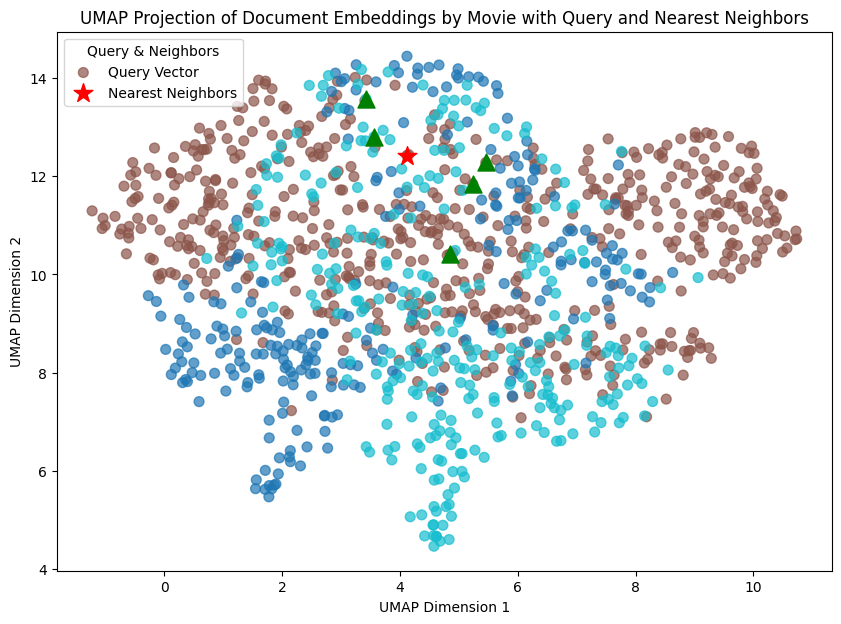

In [3]:
import json
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from ollama import embeddings as ollama_embeddings  # Assuming this is how you embed a query

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)

# Step 2: Extract embeddings, content, titles, and movie names from the JSON
embeddings = []
contents = []
titles = []
movies = []  # We'll store the movie names here

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie'])  # Extract the movie name for coloring

# Convert embeddings list into a NumPy array for further processing
embeddings = np.array(embeddings)

# Step 3: Standardize the embeddings before applying UMAP
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 4: Apply UMAP for dimensionality reduction to 2D
umap_reducer = umap.UMAP(n_neighbors=9, n_components=2, min_dist=0.5, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)

# Step 5: Create a color map for movies
unique_movies = list(set(movies))  # Get a list of unique movie names
color_map = {movie: idx for idx, movie in enumerate(unique_movies)}  # Assign a unique color index to each movie
colors = [color_map[movie] for movie in movies]  # Map each chunk to a color based on its movie

# Step 6: Embed the query
query_text = "The Force will be with you. Always."  # Example query from Star Wars
query_embedding_response = ollama_embeddings(model="mxbai-embed-large", prompt=query_text)
query_embedding = query_embedding_response['embedding']

# Standardize the query embedding using the same scaler
query_embedding_scaled = scaler.transform([query_embedding])

# Project the query embedding into the UMAP space
query_embedding_2d = umap_reducer.transform(query_embedding_scaled)

# Step 7: Nearest Neighbors Search
# Use NearestNeighbors to find the closest documents to the query
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(embeddings_scaled)  # Adjust n_neighbors if needed
distances, indices = nbrs.kneighbors(query_embedding_scaled)

# Retrieve the nearest document titles and contents
retrieved_documents = [contents[i] for i in indices[0]]
retrieved_titles = [titles[i] for i in indices[0]]

# Print the retrieved documents and their titles
print("\nRetrieved Documents:")
for i, title in enumerate(retrieved_titles):
    print(f"Neighbor {i+1}: {title}")
    print(f"Document Content (Preview): {retrieved_documents[i][:200]}...\n")  # Print only the first 200 characters

# Step 8: Visualize the UMAP projections, colored by movie, and add the query as a star
plt.figure(figsize=(10, 7))

# Plot the movie embeddings
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, cmap='tab10', s=50, alpha=0.7)

# Plot the query as a distinct marker (e.g., star)
plt.scatter(query_embedding_2d[:, 0], query_embedding_2d[:, 1], color='red', marker='*', s=200, label='Query')

# Plot the nearest neighbors as triangles
neighbor_embeddings_2d = embeddings_2d[indices[0]]
plt.scatter(neighbor_embeddings_2d[:, 0], neighbor_embeddings_2d[:, 1], color='green', marker='^', s=150, label='Nearest Neighbors')

# Add a legend with movie names
legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                     labels=unique_movies, 
                     title="Movies", 
                     loc="upper right", bbox_to_anchor=(1.15, 1))

# Add the query and neighbors legend
plt.legend(loc="upper left", title="Query & Neighbors", labels=['Query Vector', 'Nearest Neighbors'])

plt.title('UMAP Projection of Document Embeddings by Movie with Query and Nearest Neighbors')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Show the plot
plt.show()


c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Retrieved Documents:
Neighbor 1: STAR WARS
Document Content (Preview): lies along a different path than 
                         mine. The Force will be with you... 
                         always!
               Ben adjusts the lightsaber on his belt and silently step...

Neighbor 2: THE EMPIRE STRIKES BACK
Document Content (Preview): ally it is.  Life creates it, makes 
		it grow.  Its energy surrounds us 
		and binds us.  Luminous beings 
		are we...
			(Yoda pinches 
			 Luke's shoulder)
		... not this crude matter.
			(a sweepi...

Neighbor 3: STAR WARS
Document Content (Preview): VADER
                         Don't underestimate the power of the 
                         Force....

Neighbor 4: STAR WARS
Document Content (Preview): alert!
                                     VADER
                         Obi-Wan is here. The Force is with 
                         him.
                                     TARKIN
               ...

Neighbor 5: THE EMPIRE STRIKES BACK
Document

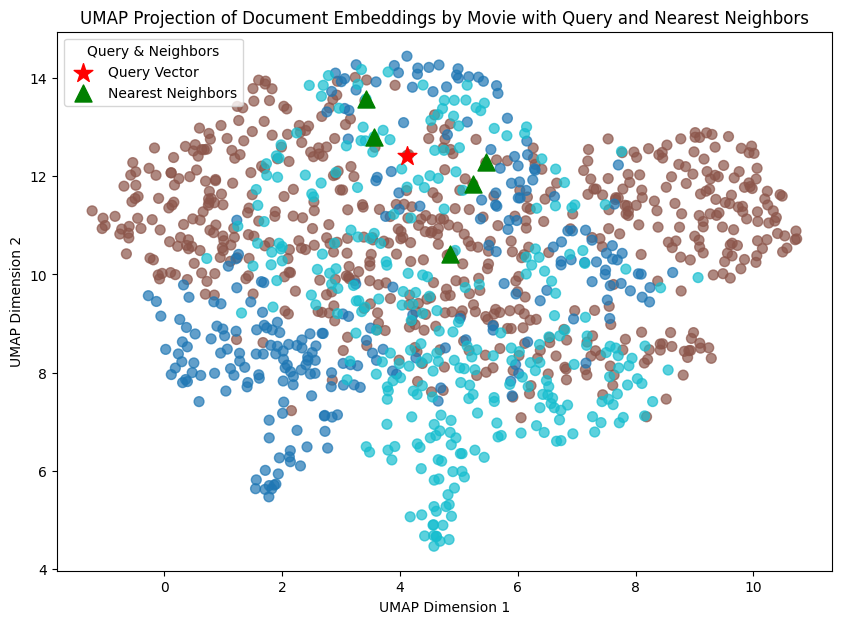

In [4]:
import json
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from ollama import embeddings as ollama_embeddings  # Assuming this is how you embed a query

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)

# Step 2: Extract embeddings, content, titles, and movie names from the JSON
embeddings = []
contents = []
titles = []
movies = []  # We'll store the movie names here

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie'])  # Extract the movie name for coloring

# Convert embeddings list into a NumPy array for further processing
embeddings = np.array(embeddings)

# Step 3: Standardize the embeddings before applying UMAP
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 4: Apply UMAP for dimensionality reduction to 2D
umap_reducer = umap.UMAP(n_neighbors=9, n_components=2, min_dist=0.5, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)

# Step 5: Create a color map for movies
unique_movies = list(set(movies))  # Get a list of unique movie names
color_map = {movie: idx for idx, movie in enumerate(unique_movies)}  # Assign a unique color index to each movie
colors = [color_map[movie] for movie in movies]  # Map each chunk to a color based on its movie

# Step 6: Embed the query
query_text = "The Force will be with you. Always."  # Example query from Star Wars
query_embedding_response = ollama_embeddings(model="mxbai-embed-large", prompt=query_text)
query_embedding = query_embedding_response['embedding']

# Standardize the query embedding using the same scaler
query_embedding_scaled = scaler.transform([query_embedding])

# Project the query embedding into the UMAP space
query_embedding_2d = umap_reducer.transform(query_embedding_scaled)

# Step 7: Nearest Neighbors Search
# Use NearestNeighbors to find the closest documents to the query
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(embeddings_scaled)  # Adjust n_neighbors if needed
distances, indices = nbrs.kneighbors(query_embedding_scaled)

# Retrieve the nearest document titles and contents
retrieved_documents = [contents[i] for i in indices[0]]
retrieved_titles = [titles[i] for i in indices[0]]

# Print the retrieved documents and their titles
print("\nRetrieved Documents:")
for i, title in enumerate(retrieved_titles):
    print(f"Neighbor {i+1}: {title}")
    print(f"Document Content (Preview): {retrieved_documents[i][:200]}...\n")  # Print only the first 200 characters

# Step 8: Visualize the UMAP projections, colored by movie, and add the query as a star
plt.figure(figsize=(10, 7))

# Plot the movie embeddings
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, cmap='tab10', s=50, alpha=0.7)

# Plot the query as a distinct marker (e.g., star)
query_plot = plt.scatter(query_embedding_2d[:, 0], query_embedding_2d[:, 1], color='red', marker='*', s=200, label='Query Vector')

# Plot the nearest neighbors as triangles
neighbor_embeddings_2d = embeddings_2d[indices[0]]
neighbor_plot = plt.scatter(neighbor_embeddings_2d[:, 0], neighbor_embeddings_2d[:, 1], color='green', marker='^', s=150, label='Nearest Neighbors')

# Add a legend with movie names
legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                     labels=unique_movies, 
                     title="Movies", 
                     loc="upper right", bbox_to_anchor=(1.15, 1))

# Add the query and neighbors legend separately to avoid confusion
plt.legend([query_plot, neighbor_plot], ['Query Vector', 'Nearest Neighbors'], loc="upper left", title="Query & Neighbors")

plt.title('UMAP Projection of Document Embeddings by Movie with Query and Nearest Neighbors')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Show the plot
plt.show()


In [148]:
import json
import numpy as np
import umap
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from ollama import embeddings as ollama_embeddings  # Assuming this is how you embed a query

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)

# Step 2: Extract embeddings, content, titles, and movie names from the JSON
embeddings = []
contents = []
titles = []
movies = []  # We'll store the movie names here

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie'])  # Extract the movie name for coloring

# Convert embeddings list into a NumPy array for further processing
embeddings = np.array(embeddings)

# Step 3: Standardize the embeddings before applying UMAP
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 4: Apply UMAP for dimensionality reduction to 3D
umap_reducer = umap.UMAP(n_neighbors=9, n_components=3, min_dist=0.5, random_state=42)
embeddings_3d = umap_reducer.fit_transform(embeddings_scaled)

# Step 5: Create a color map for movies
unique_movies = list(set(movies))  # Get a list of unique movie names
color_map = {movie: idx for idx, movie in enumerate(unique_movies)}  # Assign a unique color index to each movie
colors = [color_map[movie] for movie in movies]  # Map each chunk to a color based on its movie

# Step 6: Embed the query
query_text = "The Force will be with you. Always."  # Example query from Star Wars
query_embedding_response = ollama_embeddings(model="mxbai-embed-large", prompt=query_text)
query_embedding = query_embedding_response['embedding']

# Standardize the query embedding using the same scaler
query_embedding_scaled = scaler.transform([query_embedding])

# Project the query embedding into the UMAP 3D space
query_embedding_3d = umap_reducer.transform(query_embedding_scaled)

# Step 7: Nearest Neighbors Search
# Use NearestNeighbors to find the closest documents to the query
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(embeddings_scaled)  # Adjust n_neighbors if needed
distances, indices = nbrs.kneighbors(query_embedding_scaled)

# Retrieve the nearest document titles and contents
retrieved_documents = [contents[i] for i in indices[0]]
retrieved_titles = [titles[i] for i in indices[0]]

# Print the retrieved documents and their titles
print("\nRetrieved Documents:")
for i, title in enumerate(retrieved_titles):
    print(f"Neighbor {i+1}: {title}")
    print(f"Document Content (Preview): {retrieved_documents[i][:200]}...\n")  # Print only the first 200 characters

# Step 8: Plotly 3D scatter plot

# 3D scatter plot for movie embeddings
trace_movies = go.Scatter3d(
    x=embeddings_3d[:, 0], 
    y=embeddings_3d[:, 1], 
    z=embeddings_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=colors,  # Color by movie
        colorscale='Viridis',
        opacity=0.8
    ),
    text=movies,  # Hover text will show the movie name
    name="Movie Embeddings"
)

# 3D scatter plot for query vector
trace_query = go.Scatter3d(
    x=[query_embedding_3d[0, 0]], 
    y=[query_embedding_3d[0, 1]], 
    z=[query_embedding_3d[0, 2]],
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        symbol='diamond',  # Use a valid Plotly symbol like 'diamond'
        opacity=1.0
    ),
    text=["Query Vector"],
    name="Query Vector"
)

# 3D scatter plot for nearest neighbors
neighbor_embeddings_3d = embeddings_3d[indices[0]]  # Get the 3D positions of the neighbors
trace_neighbors = go.Scatter3d(
    x=neighbor_embeddings_3d[:, 0], 
    y=neighbor_embeddings_3d[:, 1], 
    z=neighbor_embeddings_3d[:, 2],
    mode='markers',
    marker=dict(
        size=8,
        color='green',
        symbol='cross',  # Use a valid Plotly symbol like 'cross'
        opacity=1.0
    ),
    text=["Neighbor " + str(i+1) for i in range(len(indices[0]))],  # Label the neighbors
    name="Nearest Neighbors"
)

# Combine all traces into one figure
fig = go.Figure(data=[trace_movies, trace_query, trace_neighbors])

# Update layout for better visualization
fig.update_layout(
    title="3D UMAP Projection of Document Embeddings with Query and Nearest Neighbors",
    scene=dict(
        xaxis_title='UMAP Dimension 1',
        yaxis_title='UMAP Dimension 2',
        zaxis_title='UMAP Dimension 3'
    ),
    legend=dict(
        x=0.85,
        y=1,
        bgcolor="rgba(255, 255, 255, 0.5)"
    )
)

# Show the plot
fig.show(renderer="browser")


c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Retrieved Documents:
Neighbor 1: STAR WARS
Document Content (Preview): lies along a different path than 
                         mine. The Force will be with you... 
                         always!
               Ben adjusts the lightsaber on his belt and silently step...

Neighbor 2: THE EMPIRE STRIKES BACK
Document Content (Preview): ally it is.  Life creates it, makes 
		it grow.  Its energy surrounds us 
		and binds us.  Luminous beings 
		are we...
			(Yoda pinches 
			 Luke's shoulder)
		... not this crude matter.
			(a sweepi...

Neighbor 3: STAR WARS
Document Content (Preview): VADER
                         Don't underestimate the power of the 
                         Force....

Neighbor 4: STAR WARS
Document Content (Preview): alert!
                                     VADER
                         Obi-Wan is here. The Force is with 
                         him.
                                     TARKIN
               ...

Neighbor 5: THE EMPIRE STRIKES BACK
Document

In [5]:
import json
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from ollama import embeddings as ollama_embeddings  # Assuming this is how you embed a query

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)

# Step 2: Extract embeddings, content, titles, and movie names from the JSON
embeddings = []
contents = []
titles = []
movies = []  # We'll store the movie names here

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie'])  # Extract the movie name for coloring

# Convert embeddings list into a NumPy array for further processing
embeddings = np.array(embeddings)

# Step 3: Standardize the embeddings (this applies to both retrieval methods)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 4: Apply UMAP for dimensionality reduction to 3D
umap_reducer = umap.UMAP(n_neighbors=9, n_components=3, min_dist=0.5, random_state=42)
embeddings_umap = umap_reducer.fit_transform(embeddings_scaled)

# Step 5: Embed the query
query_text = "The Force will be with you. Always."  # Example query from Star Wars
query_embedding_response = ollama_embeddings(model="mxbai-embed-large", prompt=query_text)
query_embedding = query_embedding_response['embedding']

# Standardize the query embedding using the same scaler
query_embedding_scaled = scaler.transform([query_embedding])

# Step 6: Nearest Neighbors Search (Without UMAP)
nbrs_original = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(embeddings_scaled)
distances_original, indices_original = nbrs_original.kneighbors(query_embedding_scaled)

# Step 7: Nearest Neighbors Search (With UMAP)
nbrs_umap = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(embeddings_umap)
distances_umap, indices_umap = nbrs_umap.kneighbors(umap_reducer.transform(query_embedding_scaled))

# Step 8: Retrieve documents for both approaches
retrieved_original = [contents[i] for i in indices_original[0]]
retrieved_umap = [contents[i] for i in indices_umap[0]]

# Print the retrieved documents
print("\nRetrieved Documents (Without UMAP):")
for i, title in enumerate([titles[i] for i in indices_original[0]]):
    print(f"Original Neighbor {i+1}: {title}")
    print(f"Document Content (Preview): {retrieved_original[i][:200]}...\n")  # Print only the first 200 characters

print("\nRetrieved Documents (With UMAP):")
for i, title in enumerate([titles[i] for i in indices_umap[0]]):
    print(f"UMAP Neighbor {i+1}: {title}")
    print(f"Document Content (Preview): {retrieved_umap[i][:200]}...\n")  # Print only the first 200 characters


c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Retrieved Documents (Without UMAP):
Original Neighbor 1: STAR WARS
Document Content (Preview): lies along a different path than 
                         mine. The Force will be with you... 
                         always!
               Ben adjusts the lightsaber on his belt and silently step...

Original Neighbor 2: THE EMPIRE STRIKES BACK
Document Content (Preview): ally it is.  Life creates it, makes 
		it grow.  Its energy surrounds us 
		and binds us.  Luminous beings 
		are we...
			(Yoda pinches 
			 Luke's shoulder)
		... not this crude matter.
			(a sweepi...

Original Neighbor 3: STAR WARS
Document Content (Preview): VADER
                         Don't underestimate the power of the 
                         Force....

Original Neighbor 4: STAR WARS
Document Content (Preview): alert!
                                     VADER
                         Obi-Wan is here. The Force is with 
                         him.
                                     TARKIN
             

In [7]:
from langchain_ollama.llms import OllamaLLM

# Initialize the model
llm = OllamaLLM(model='llama3.2:1b')

# Define the retrieved documents (context)
retrieved_original = [
    'lies along a different path than \n                         mine. The Force will be with you... \n                         always!\n               Ben adjusts the lightsaber on his belt and silently steps \n               out of the command office, then disappears down a long grey \n               hallway. Chewbacca barks a comment and Han shakes his head \n               in agreement.',
    "ally it is.  Life creates it, makes \n\t\tit grow.  Its energy surrounds us \n\t\tand binds us.  Luminous beings \n\t\tare we...\n\t\t\t(Yoda pinches \n\t\t\t Luke's shoulder)\n\t\t... not this crude matter.\n\t\t\t(a sweeping gesture)\n\t\tYou must feel the Force around you.\n\t\t\t(gesturing)\n\t\tHere, between you... me... the \n\t\ttree... the rock... everywhere!  \n\t\tYes, even between this land and \n\t\tthat ship!\n\t\t\t\tLUKE\n\t\t\t(discouraged)\n\t\tYou want the impossible.\nQuietly Yoda turns toward the X-wing fighter.  With his eyes closed and \nhis head bowed, he raises his arm and points at the ship.\nSoon, the fighter rises above the water and moves forward as Artoo \nbeeps in terror and scoots away.\nThe entire X-wing moves majestically, surely, toward the shore.  Yoda",
    "VADER\n                         Don't underestimate the power of the \n                         Force.",
    "alert!\n                                     VADER\n                         Obi-Wan is here. The Force is with \n                         him.\n                                     TARKIN\n                         If you're right, he must not be \n                         allowed to escape.",
    "But Han and Leia will die if I \n\t\tdon't.\n\t\t\t\tBEN'S VOICE\n\t\tYou don't know that.\nLuke looks toward the voice in amazement.  Ben has materialized as a \nreal, slightly shimmering image near Yoda.  The power of his presence \nstops Luke.\n\t\t\t\tBEN\n\t\tEven Yoda cannot see their fate.\n\t\t\t\tLUKE\n\t\tBut I can help them!  I feel \n\t\tthe Force!\n\t\t\t\tBEN\n\t\tBut you cannot control it.  This \n\t\tis a dangerous time for you, \n\t\twhen you will be tempted by the \n\t\tdark side of the Force.\n\t\t\t\tYODA\n\t\tYes, yes.  To Obi-Wan you listen.\n\t\tThe cave.  Remember your failure \n\t\tat the cave!"
]

# Query to ask the model
query = "What is the role of the Force in guiding Luke?"

# Format the context into a single string
context = "\n\n".join(retrieved_original)

# Formulate the input for the model (you can adjust how you pass the context if needed)
input_text = f"Context: {context}\n\nQuestion: {query}"

print(input_text)

# Invoke the model with the context and the question
response = llm.invoke(input_text)

# Print the model's response
print("Response from the model:")
print(response)


Context: lies along a different path than 
                         mine. The Force will be with you... 
                         always!
               Ben adjusts the lightsaber on his belt and silently steps 
               out of the command office, then disappears down a long grey 
               hallway. Chewbacca barks a comment and Han shakes his head 
               in agreement.

ally it is.  Life creates it, makes 
		it grow.  Its energy surrounds us 
		and binds us.  Luminous beings 
		are we...
			(Yoda pinches 
			 Luke's shoulder)
		... not this crude matter.
			(a sweeping gesture)
		You must feel the Force around you.
			(gesturing)
		Here, between you... me... the 
		tree... the rock... everywhere!  
		Yes, even between this land and 
		that ship!
				LUKE
			(discouraged)
		You want the impossible.
Quietly Yoda turns toward the X-wing fighter.  With his eyes closed and 
his head bowed, he raises his arm and points at the ship.
Soon, the fighter rises above the water 

In [8]:
from langchain_ollama.llms import OllamaLLM

# Initialize the model
llm = OllamaLLM(model='llama3.2:1b')

# Define the retrieved documents (context)
retrieved_original = [
    'lies along a different path than \n                         mine. The Force will be with you... \n                         always!\n               Ben adjusts the lightsaber on his belt and silently steps \n               out of the command office, then disappears down a long grey \n               hallway. Chewbacca barks a comment and Han shakes his head \n               in agreement.',
    "ally it is.  Life creates it, makes \n\t\tit grow.  Its energy surrounds us \n\t\tand binds us.  Luminous beings \n\t\tare we...\n\t\t\t(Yoda pinches \n\t\t\t Luke's shoulder)\n\t\t... not this crude matter.\n\t\t\t(a sweeping gesture)\n\t\tYou must feel the Force around you.\n\t\t\t(gesturing)\n\t\tHere, between you... me... the \n\t\ttree... the rock... everywhere!  \n\t\tYes, even between this land and \n\t\tthat ship!\n\t\t\t\tLUKE\n\t\t\t(discouraged)\n\t\tYou want the impossible.\nQuietly Yoda turns toward the X-wing fighter.  With his eyes closed and \nhis head bowed, he raises his arm and points at the ship.\nSoon, the fighter rises above the water and moves forward as Artoo \nbeeps in terror and scoots away.\nThe entire X-wing moves majestically, surely, toward the shore.  Yoda",
    "VADER\n                         Don't underestimate the power of the \n                         Force.",
    "alert!\n                                     VADER\n                         Obi-Wan is here. The Force is with \n                         him.\n                                     TARKIN\n                         If you're right, he must not be \n                         allowed to escape.",
    "But Han and Leia will die if I \n\t\tdon't.\n\t\t\t\tBEN'S VOICE\n\t\tYou don't know that.\nLuke looks toward the voice in amazement.  Ben has materialized as a \nreal, slightly shimmering image near Yoda.  The power of his presence \nstops Luke.\n\t\t\t\tBEN\n\t\tEven Yoda cannot see their fate.\n\t\t\t\tLUKE\n\t\tBut I can help them!  I feel \n\t\tthe Force!\n\t\t\t\tBEN\n\t\tBut you cannot control it.  This \n\t\tis a dangerous time for you, \n\t\twhen you will be tempted by the \n\t\tdark side of the Force.\n\t\t\t\tYODA\n\t\tYes, yes.  To Obi-Wan you listen.\n\t\tThe cave.  Remember your failure \n\t\tat the cave!"
]

# Query to ask the model
query = "How did the Force guide Luke Skywalker through his trials and interactions with Obi-Wan and Yoda?"

# Constructing the system prompt
system_prompt = (
    "You are a Jedi historian and scholar of the Force, entrusted with documenting and interpreting the teachings, trials, and wisdom of the Jedi Order. "
    "Your duty is to analyze and explain the mystical ways of the Force in guiding the Jedi through their journeys, while being precise, concise, and insightful.\n"
    "You are now tasked with explaining how the Force shaped the path of Jedi Knight Luke Skywalker during his trials, interactions with Obi-Wan Kenobi, and guidance from Yoda.\n"
    "Use the context provided below and answer in no more than four sentences, distilling the essence of the Force's influence over Luke's journey.\n\n"
)

# Combine the system prompt, context, and question
context = "\n\n".join(retrieved_original)
input_text = f"{system_prompt}Context:\n{context}\n\nQuestion: {query}"


print(input_text,'\n')

# Invoke the model with the system prompt, context, and the question
response = llm.invoke(input_text)

# Print the model's response
print("Response from the model:")
print(response)


You are a Jedi historian and scholar of the Force, entrusted with documenting and interpreting the teachings, trials, and wisdom of the Jedi Order. Your duty is to analyze and explain the mystical ways of the Force in guiding the Jedi through their journeys, while being precise, concise, and insightful.
You are now tasked with explaining how the Force shaped the path of Jedi Knight Luke Skywalker during his trials, interactions with Obi-Wan Kenobi, and guidance from Yoda.
Use the context provided below and answer in no more than four sentences, distilling the essence of the Force's influence over Luke's journey.

Context:
lies along a different path than 
                         mine. The Force will be with you... 
                         always!
               Ben adjusts the lightsaber on his belt and silently steps 
               out of the command office, then disappears down a long grey 
               hallway. Chewbacca barks a comment and Han shakes his head 
               i

In [9]:
print("Response from the model:")
print(response)

Response from the model:
The Force played a profound role in guiding Luke Skywalker's journey, particularly during his encounters with Obi-Wan Kenobi and Yoda. The Force allowed Luke to tap into its energy, which helped him navigate complex moral dilemmas, understand the motivations of others, and make crucial decisions that impacted the fate of those around him.

Specifically, the Force guided Luke through the following ways:

1. **Guiding Obi-Wan's words**: Through his amazement at Ben's presence, Luke was reminded to trust in Yoda's guidance and wisdom.
2. **Yoda's cryptic messages**: The Force conveyed Yoda's message about Tarkin's intentions and the danger of Vader's influence, which helped Luke understand the stakes and make a crucial decision.
3. **The cave encounter**: The Force facilitated Luke's understanding of his failure at the cave and its consequences, allowing him to re-evaluate his actions and ultimately decide on a path that would lead him to confront Vader.

Overall,

In [151]:
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain_ollama.llms import OllamaLLM

llm = OllamaLLM(model='llama3.2:1b')


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [153]:
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

query_text = "The Force will be with you. Always."  # Example query from Star Wars


c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: Us

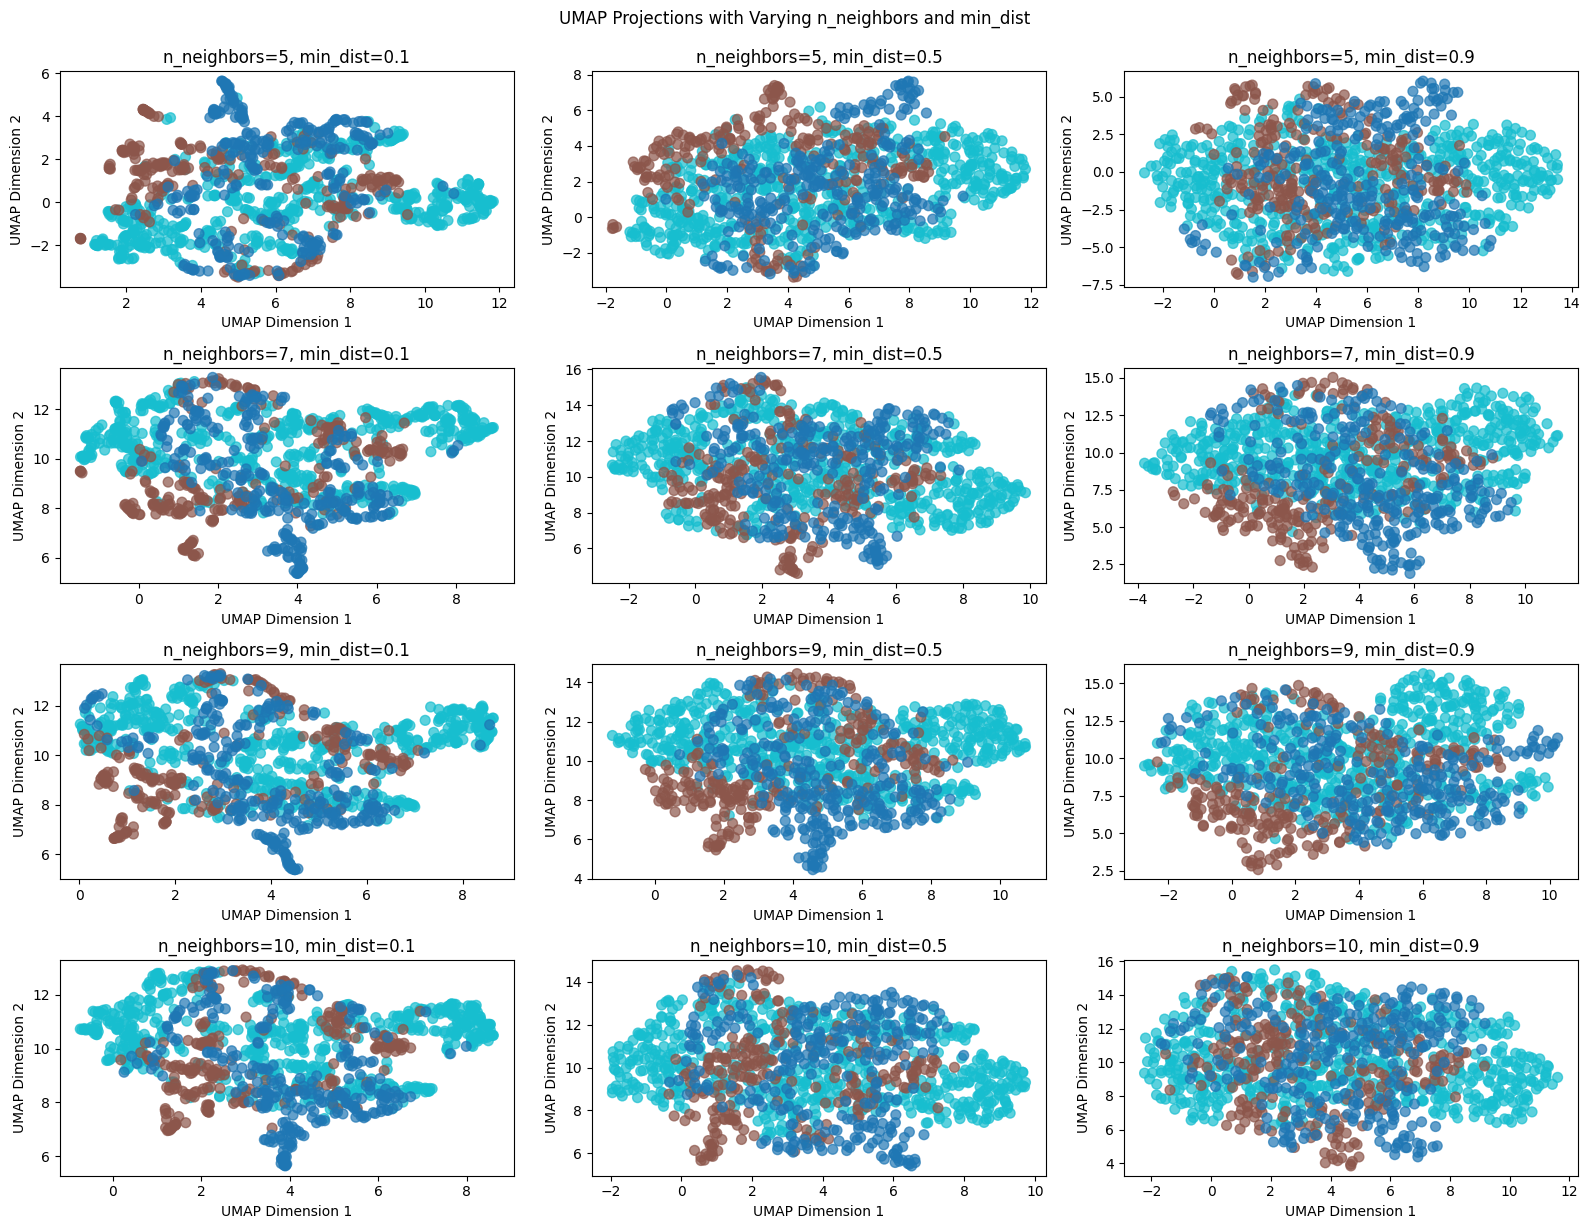

In [138]:
import json
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)

# Step 2: Extract embeddings, content, titles, and movie names from the JSON
embeddings = []
contents = []
titles = []
movies = []  # We'll store the movie names here

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie'])  # Extract the movie name for coloring

# Convert embeddings list into a NumPy array for further processing
embeddings = np.array(embeddings)

# Step 3: Standardize the embeddings before applying UMAP
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 4: Set up the grid of hyperparameters to search over
n_neighbors_values = [5, 7, 9, 10]  # Range of n_neighbors to try
min_dist_values = [0.1, 0.5, 0.9]      # Range of min_dist values to try

# Create a color map for movies
unique_movies = list(set(movies))  # Get a list of unique movie names
color_map = {movie: idx for idx, movie in enumerate(unique_movies)}  # Assign a unique color index to each movie
colors = [color_map[movie] for movie in movies]  # Map each chunk to a color based on its movie

# Step 5: Perform the grid search and plot each result
plt.figure(figsize=(16, 12))  # Adjust figure size to display multiple plots

plot_num = 1
for n_neighbors in n_neighbors_values:
    for min_dist in min_dist_values:
        # Apply UMAP with the current set of hyperparameters
        umap_reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, random_state=42)
        embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)
        
        # Plot the UMAP projections
        plt.subplot(len(n_neighbors_values), len(min_dist_values), plot_num)
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, cmap='tab10', s=50, alpha=0.7)
        
        plt.title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        
        plot_num += 1

# Adjust layout and show the plots
plt.tight_layout()
plt.suptitle('UMAP Projections with Varying n_neighbors and min_dist', y=1.02)
plt.show()
